In [242]:
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [321]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    assert n > 0, 'n must be a positive integer'  # n must be a positive integer

    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers

# G = np.random.rand(3, 3)  # Create a random 3x3 matrix
# print(G)  # Print the matrix G
# print('\n\n')
# n = 1  # Compute the sum of powers up to the 3rd power
# print(sum_of_powers(G, n))  # Print the result


In [324]:
def generate_matrix_with_infinity_norm_less_than_one(n):
    # Generate an n x n matrix with random values between -0.5 and 0.5
    assert n > 1, 'n must be greater than 1'

    A = (np.random.rand(n, n) - 0.5)*2
    
    # Scale each row so that the sum of the absolute values is less than 1
    for i in range(n):
        row_sum = np.sum(np.abs(A[i, :]))
        scaling_factor = np.random.uniform(low=0.0, high=1.0) / row_sum
        A[i, :] *= scaling_factor

    np.fill_diagonal(A, 0)
        
    return A


def generate_matrix_with_2_norm_less_than_one(n):

    assert n > 1, 'n must be greater than 1'

    # Generate an n x n matrix with random values
    A = (np.random.randn(n, n) - 0.5)*2
    
    # Perform SVD
    U, s, Vh = np.linalg.svd(A)
    
    # Scale singular values to ensure all are less than 1
    s_scaled = np.random.uniform(low=0.0, high=1.0, size=s.shape)
    
    # Reconstruct the matrix with scaled singular values
    A_scaled = np.dot(U, np.dot(np.diag(s_scaled), Vh))

    np.fill_diagonal(A_scaled, 0)
    
    return A_scaled


def generate_weighted_cycle(n):

    assert n > 2, 'n must be greater than 2'
    
    # Create a cycle graph with n nodes
    G = nx.cycle_graph(n)
    
    # Assign random weights to the edges
    for (u, v) in G.edges():
        G[u][v]['weight'] = np.random.rand()
        G[v][u]['weight'] = np.random.rand()
    
    return nx.adjacency_matrix(G).toarray()

# Agent Utilitiy

In [325]:
def agent_utility(q, x, G, i):
    """
    Calculate the quadratic utility for agent i.
    
    Parameters:
    - q (numpy array): The linear coefficients for each agent.
    - x (numpy array): The choices or quantities selected by each agent.
    - g (numpy matrix or 2D array): The interaction coefficients between agents.
    - i (int): The index of the agent for whom to calculate the utility.
    
    Returns:
    - float: The calculated utility for agent i.
    """

    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert G.shape[0] == G.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'
    
    # Linear term for agent i
    linear_term = q[i] * x[i]
    
    # Quadratic term for agent i
    quadratic_term = -0.5 * x[i]**2
    
    # Interaction term for agent i with all other agents j
    interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
    
    # Total utility for agent i
    utility_i = linear_term + quadratic_term + interaction_term
    
    return utility_i


# Example usage
q = np.array([1, 2, 3])  # Linear coefficients for agents
# x = np.array([0.5, 1.5, 2.5])  # Choices of agents
x = np.array([random.uniform(0, 3) for i in range(3)])
print(x)
g = np.array([[0, 0.1, 0.2],  # Interaction coefficients between agents
              [0.1, 0, 0.3],
              [0.2, 0.3, 0]])
# i = 0  # Agent index for whom we're calculating the utility

for i in range(3):
    utility_i = agent_utility(q, x, g, i)
    print(f"The calculated utility for agent {i} is: {utility_i}")

[2.71893098 2.95360751 0.70703187]
The calculated utility for agent 0 is: -2.164901514402869
The calculated utility for agent 1 is: 0.11576247256241978
The calculated utility for agent 2 is: 0.8601860143805244


# Socially Optimal Solution

In [327]:
def total_utility(x, q, g):
    """
    Calculate the total utility for all agents by summing individual utilities.
    """
    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert g.shape[0] == g.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'

    return sum(agent_utility(q, x, g, i) for i in range(len(q)))


def find_social_optimum(q, g, bounds):
    """
    Find the socially optimal solution that maximizes the total utility.
    """
    assert len(q) == g.shape[0] == g.shape[1], 'The number of linear coefficients must match the number of agents, and the interaction matrix must be square'
    assert len(bounds) == len(q), 'The number of bounds must match the number of agents'
    
    num_agents = len(q)
    x0 = np.ones(num_agents)  # Initial guess for the optimization
    
    # Minimize the negative of the total utility to find the maximum total utility
    objective = lambda x: -total_utility(x, q, g)
    opt_result = minimize(objective, x0, bounds=bounds, method='SLSQP')

    return opt_result

# Individual Maximization

In [328]:
def optimize_agent_i(q, g, x, i, bounds_i):
    """
    Optimize the effort of agent i to maximize their utility.
    
    Parameters:
    - q: Cost vector.
    - g: Interaction matrix.
    - x: Vector of current efforts by all agents.
    - i: The index of the agent to optimize for.
    - bounds_i: Bounds for the optimization of agent i's effort.
    
    Returns:
    - The optimized effort for agent i.
    """
    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert g.shape[0] == g.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'

    # Define the objective function to be minimized (negative utility for maximization)
    def objective(effort):
        # Update agent i's effort in the vector
        x_new = np.array(x)
        x_new[i] = effort
        # Return negative utility to perform maximization
        return -agent_utility(q, x_new, g, i)
    
    # Initial guess for the effort of agent i
    x0 = [x[i]]
    
    # Perform the optimization
    result = minimize(objective, x0, bounds=[bounds_i], method='SLSQP')
    
    if result.success and result.x[0] > 0:
        # If optimization is successful, return the optimized effort
        return result.x[0]
    elif result.success and result.x[0] <= 0:
        # If optimization is successful and yields non-positive effort, return zero
        return 0
    else:
        # If optimization fails ?? idk!
        print("Optimization failed:", result.message)
        return 0  # or return x[i] to keep the original effort



def maximize_individual_utilities_iteratively(q, g, initial_x, bounds, tol=1e-4, max_iter=100):
    """
    Iteratively maximize each agent's utility until convergence.
    """
    x = np.copy(initial_x)
    for iteration in range(max_iter):
        x_new = np.copy(x)
        for i in range(len(q)):
            x_new[i] = optimize_agent_i(q, g, x, i, bounds[i])

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            # print(f"Convergence achieved after {iteration + 1} iterations.")
            break
        x = x_new
    else:
        print("Max iterations reached without convergence.")

    return x

# Function for creating different types of networks

In [349]:
n = 10
# q = np.random.rand(n)  # Random linear coefficients for agents
q = np.ones(n)
max_hops = 30
# x_init = soc_opt_result.x
x_init = np.ones(n)

flag = True
while flag:
    # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
    g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
    # g = generate_weighted_cycle(n)
    norm_inf_g = np.linalg.norm(g, ord=np.inf)
    norm_2_g = np.linalg.norm(g, ord=2)
    if (norm_2_g < 1 or norm_inf_g < 1):
        flag = False

# print the norm of g
print(np.linalg.norm(g, ord=np.inf))
print(np.linalg.norm(g, ord=2))

bounds = [(0, None)] * n  # Assume non-negative choices

opt_result = find_social_optimum(q, g, bounds)
print(f"\nSocially optimal solution: {opt_result.x}")
print(f"Maximum total utility: {-opt_result.fun}\n")


utility_list = []
x_nash_list = []
util_soc_op_list = []

for hops in range(1, max_hops + 1):
    x_nash = 0
    utility = 0
    soc_opt_result = 0
    
    # compute nash equilibrium
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(g, hops), x_init, bounds)
    x_nash_list.append(x_nash)

    # compute total utility
    utility = total_utility(x_nash, q, sum_of_powers(g, hops))
    utility_list.append(utility)

    # compute social optimum
    soc_opt_result = find_social_optimum(q, sum_of_powers(g, hops), bounds)
    util_soc_op_list.append(-soc_opt_result.fun)


I = np.identity(n)
soc_opt_I = find_social_optimum(q, I+g, bounds)
soc_opt_n = find_social_optimum(q, -g, bounds)
soc_opt_g = find_social_optimum(q, I-g, bounds)
soc_opt_hmm = find_social_optimum(q, np.linalg.inv(I-g), bounds)

print(f"Efforts at hop {max_hops}: {x_nash_list[-1]}")
print(f"Total utility at hop {max_hops}: {total_utility(x_nash_list[-1], q, sum_of_powers(g, max_hops))}\n")



# I = np.identity(n)

# x_nash_mirror = maximize_individual_utilities_iteratively(q, -g, x_init, bounds)
# print(f"Efforts for -G: {x_nash_mirror}")
# print(f"Total utility for -G: {total_utility(x_nash_mirror, q, -g)}\n")

1.5038127419615888
0.8427717237292641

Socially optimal solution: [4.41278854e+00 1.15801090e+00 5.15919216e+00 5.10472206e+00
 6.82681978e+00 5.89722421e+00 4.98169085e-13 3.22403322e-13
 1.97221484e+00 1.82005806e+00]
Maximum total utility: 16.175520585261776

Efforts at hop 30: [1.05195419 0.9980506  0.75304281 1.14468596 1.48486622 0.82381275
 0.98506999 1.01037668 1.22642233 0.99096673]
Total utility at hop 30: 5.842177017632657



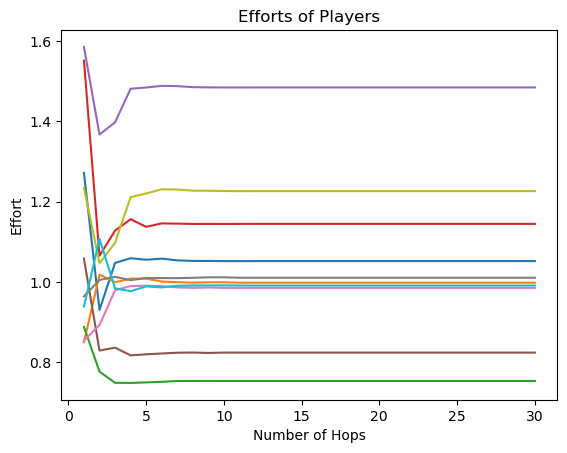

Total utility at hop 1: 6.616976426734508


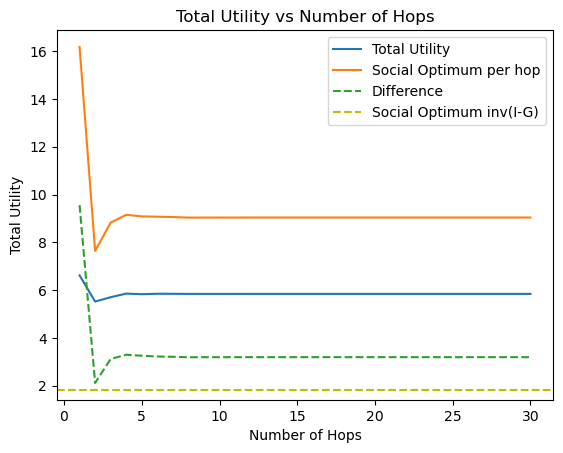

In [354]:
plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players")
plt.show()

# print the total utility at first hop
print(f"Total utility at hop 1: {utility_list[0]}")
plt.plot(range(1, max_hops + 1), utility_list, label='Total Utility')
plt.plot(range(1, max_hops + 1), util_soc_op_list, label='Social Optimum per hop')
# plot the difference between the social optimum pe hop and the total utility per hop
diff = [-utility_list[i] + util_soc_op_list[i] for i in range(max_hops)]
plt.plot(range(1, max_hops + 1), diff, label='Difference', linestyle='--')
# plt.axhline(y=-soc_opt_I.fun, color='r', linestyle='--', label='Social Optimum I+G')
# plt.axhline(y=-soc_opt_n.fun, color='g', linestyle='--', label='Social Optimum -G')
# plt.axhline(y=-soc_opt_g.fun, color='b', linestyle='--', label='Social Optimum I-G')
soc_opt_hmm = find_social_optimum(q, np.linalg.inv(I-g), bounds)
plt.axhline(y=-soc_opt_hmm.fun, color='y', linestyle='--', label='Social Optimum inv(I-G)')
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title("Total Utility vs Number of Hops")
plt.legend(loc='upper right')
plt.show()

# print the final utility difference
# print(f"Utility difference between hop {max_hops} and social optimum: {utility_list[-1] + soc_opt_result.fun}\n")

In [284]:
# prrint the efforts at last two hops
print(f"Efforts at hop {max_hops - 1}: {x_nash_list[-2]}")
print(f"Efforts at hop {max_hops}: {x_nash_list[-1]}\n")
# print the norm difference between the efforts at last two hops
print(f"Norm difference between the efforts at hop {max_hops - 1} and hop {max_hops}: {np.linalg.norm(x_nash_list[-2] - x_nash_list[-1])}\n")

Efforts at hop 29: [0.00000000e+00 3.07333175e-01 4.03867614e-02 6.27616132e-01
 2.48102077e-01 1.80411242e-16 0.00000000e+00 1.10716678e-01
 1.80411242e-16 1.95156391e-18]
Efforts at hop 30: [0.00000000e+00 3.07185545e-01 4.04014905e-02 6.27595590e-01
 2.48036626e-01 2.42861287e-17 5.55111512e-17 1.10591402e-01
 0.00000000e+00 0.00000000e+00]

Norm difference between the efforts at hop 29 and hop 30: 0.00020594040432579298



In [67]:
n = 20
max_hops = 20
q = np.random.rand(n)  # Random linear coefficients for agents
bounds = [(0, None)] * n  # Assume non-negative choices
x_init = np.ones(n)

flag = True
while flag:
    # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
    # norm_g = np.linalg.norm(g, ord=np.inf)
    g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
    norm_g = np.linalg.norm(g, ord=2)
    if norm_g < 1:
        flag = False
G = g

In [38]:
soc_opt_result = find_social_optimum(q, G, bounds)

x_nash_list1 = []
for hops in range(1, max_hops + 1):
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(G, hops), x_init, bounds)
    x_nash_list1.append(x_nash)

# plot the total utility as a function of the number of hops
plt.figure()
plt.plot(range(1, max_hops + 1), [total_utility(x_nash, q, sum_of_powers(G, i)) for i, x_nash in enumerate(x_nash_list1, 1)])
# plot socially optimal utility
plt.axhline(-soc_opt_result.fun, color='r', linestyle='--', label='Socially Optimal')
plt.xlim(1, max_hops)
plt.ylim(-soc_opt_result.fun/2, 0.5-soc_opt_result.fun)
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title(f"Total Utility - Cycle Graph with {n} nodes")
plt.show()

Max iterations reached without convergence.


KeyboardInterrupt: 